# Exploring Income Factors

I want to explore the what factors are most predictive of income in America.

This project is a large undertaking for a single computer, and as such will be split into 3 parts. In the first part, I will import and combine the data. The second part will pertain to my data cleaning and feature selection. Finally, I will perform descriptive modeling with the most important factors towards predicting income in the third part.

In [1]:
import numpy as np
import pandas as pd
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import savReaderWriter

# Part 2: Selecting Features

Now that I have combined all the GSS data one larger one, I must choose which features to use. The goal of this part of the project is to produce a data set entirely ready for descriptive modeling using linear mixed-effect models.

The data set has 407 features far too many too analyze all of them with complete scurtiny in a model. I must determine which features are most important and should be kept, and which should be thrown away.

The first thing I will do is import the combined data set I created in part 1.

In [2]:
work_mult = pd.read_csv('C:\\Code\\SSP\\workmult.csv')

work_mult = work_mult.drop('Unnamed: 0',1)

##### work_mult.shape

In [3]:
work_mult.head()

,SPISCO88,OWNGUN,WRKWAYUP,PRAY,LIBMIL,YEAR,SPHRS1,GENDER10,MADEG,ABHLTH,...,MAR3,ABNOMORE,RELHH11,SPEVWORK,WRKSTAT,LIFE,PILLOK,SPKMIL,CONFINAN,SOCREL
0,2419.0,2.0,4.0,6.0,2.0,2016.0,-1.0,0.0,1.0,1.0,...,5.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0
1,NaN,0.0,2.0,6.0,0.0,2016.0,-1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,5.0
2,4190.0,2.0,0.0,1.0,2.0,2016.0,-1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,1.0,5.0,1.0,0.0,1.0,3.0,0.0
3,1223.0,1.0,1.0,3.0,2.0,2016.0,55.0,0.0,1.0,1.0,...,5.0,2.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,2.0
4,2131.0,2.0,0.0,6.0,2.0,2016.0,80.0,0.0,1.0,1.0,...,5.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0,0.0


# Cleaning Data

Before I begin featute selection, I will clean the data. 

First, I will drop any columns with null values. Then, I will drop indexes, or respondants, which did not provide income data, either because it was unapplicable or they chose not to answer.

In [4]:
null_col = work_mult.columns[work_mult.isna().any()].tolist()
work_mult = work_mult.drop(null_col,1)
print('dropped columns {} with nulls'.format(null_col))

dropped columns ['SPISCO88', 'MAISCO88', 'PAISCO88', 'ISCO88'] with nulls


In [5]:
# drop people for whom income was non-applicable
work_mult = work_mult.drop(work_mult[work_mult['CONINC']==0].index)

In [6]:
# drop people for whom income was non-applicable
work_mult = work_mult.drop(work_mult[work_mult['REALRINC']==0].index)

In [7]:
work_mult[work_mult['REALRINC']==0].index

Int64Index([], dtype='int64')

# Refining Income

I want to visually inspect the outcome to make sure it will do well in linear modeling. Specifically, I want to check for any outliers and to see how noraml the distribution of the Income and make prepare it for modeling.

I'll start with the distribution.

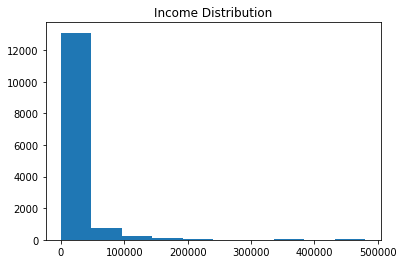

In [8]:
plt.hist(work_mult['REALRINC'])
plt.title('Income Distribution')
plt.show()

The income is certainly not normally distributed. And while a normally distributed outcome is not an absolute requirement of linear modeling, it usually provides more accurate results and less headaches down the line (like producing normal errors, which is a requirement).

I will take the square root of the income to make it more normal and model that. This means that any I models I create will relate to the square root of the income, not directly the income itself. This will add a layer of complexity when interpreting my results, but will be a small price to pay for accuraccy. 

In [9]:
work_mult['REALINCSQRT'] = np.sqrt(work_mult['REALRINC'])

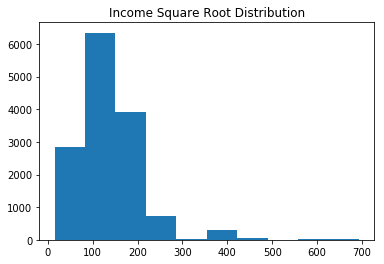

In [10]:
plt.hist(work_mult['REALINCSQRT'])
plt.title('Income Square Root Distribution')
plt.show()

It worked, the income looks much more normally distributed, but there still seem to be too many outliers to really tell. I want to identify and remove those outliers if they exist.

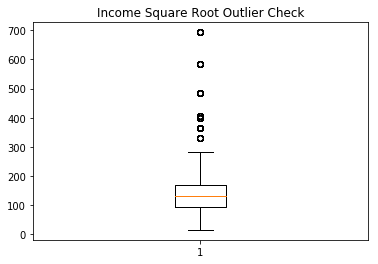

In [11]:
plt.boxplot(work_mult['REALINCSQRT'])
plt.title('Income Square Root Outlier Check')
plt.show()

There, appear to be a few outliers in the outcome. I need to remove them. 

In [12]:
descr = list(work_mult['REALINCSQRT'].describe())
# set outlier limit using IQR
outlier = (descr[6] - descr[4]) * 1.5 + descr[6]
work_mult['REALINCSQRT'].describe()

count    14287.000000
mean       138.899833
std         77.230981
min         15.297059
25%         92.754380
50%        131.174502
75%        168.789810
max        692.924579
Name: REALINCSQRT, dtype: float64

In [13]:
new_inc = []
for inc in work_mult['REALINCSQRT']:
    if inc < outlier:
        new_inc.append(inc)
    else:
        new_inc.append(-1)
        
work_mult['REALINCSQRT'] = new_inc

In [14]:
work_mult = work_mult.drop(work_mult[work_mult['REALINCSQRT']==-1].index)

In [15]:
work_mult.shape

(13827, 404)

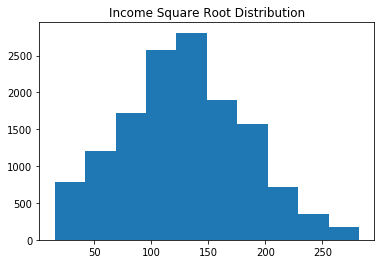

In [16]:
plt.hist(work_mult['REALINCSQRT'])
plt.title('Income Square Root Distribution')
plt.show()

This leaves me with a data with 13,000 rows, down from 24,000, of respondants applicable to this model investigation. The outcome now looks almost perfectly normally distributed as well.

Now that have prepared the outcome for modeling, I must prepare my features as well.

# Cleaning Continuous Features

I will start by cleaning the continuous features in my data. It is important to note that none of the variables here are completely continuous, but are integer based. Since the GSS is survey data, it is of course mostly categorical data. Still, I will treat the ordinal continuous variables as continuous since it will be more effective for linear modeling.

I have 7 continuous features in my data set. Not too many out of 402 total. The continuous features are as follows:

__EDUC__ is the respondant's education level in years of formal schooling (from 0-20), __SPEDUC__ is the respondant's spouse's education level, __PAEDUC__ is the respondant's Father's education level, __MAEDUC__ is the respondant's mothers's education level, __WEEKSWRK__ is the number of weeks per year the respondant works, and __HRS1__ is how many hours the respondant worked last week.

But before I jump into testing each of these, there are a few continuous features I want to clean. 

In [17]:
continuous_feat = ['EDUC','SPEDUC','PAEDUC','MAEDUC','WEEKSWRK','HRS1','HRS2']

In [18]:
# drop respondants who have to age information
work_mult = work_mult.drop(work_mult[work_mult['AGE']==99].index)
work_mult.reset_index(drop=True,inplace=True)

There were many people who did not give information about their own, spouse's, or parent's education. I will treat those missing answers as having zero education, under the theory that these people do not respond to this question because they were ashamed of their own low education level, do not know(missing parents), or did not apply (no spouse). 

All these relationships are well represented with a value of 0. I will also add a categorical variable to my data resprents people who gave no response, so my model can differ between a true education level of 0 and a 0 representing no data.

In [19]:
for ed in ['EDUC','SPEDUC','PAEDUC','MAEDUC']:
    clean = []
    no_data = []
    for value in work_mult[ed]:
        if value==97 or value==98 or value==99:
            clean.append(0)
            no_data.append(2)
            
        else:
            clean.append(value)
            no_data.append(1)
    work_mult[ed] = clean   
    work_mult['{}_NA'.format(ed)] = no_data       

Set the values for people who did not respond of found this question to be non-applicable to zero weeks worked. Do the same for hours worked.

In [20]:
clean = []
for value in work_mult['WEEKSWRK']:
    if value == 98 or value == 99 or value ==-1:
        clean.append(0)
    else:
        clean.append(value)
        
work_mult['WEEKSWRK'] = clean

In [21]:
clean = []
for value in work_mult['HRS1']:
    if value == 98 or value == 99 or value ==-1:
        clean.append(0)
    else:
        clean.append(value)
        
work_mult['HRS1'] = clean

## Visualizig Continuous Features

Now that my continuous features have been appropriately cleaned, I will plot the relationship between each of them and the outcome, the square root of the income. Since I want to use these in a linear model, it is important that they have a near linear relationship with the outcome.

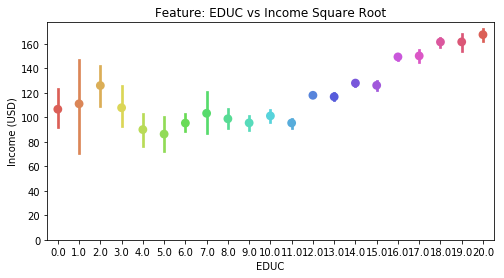

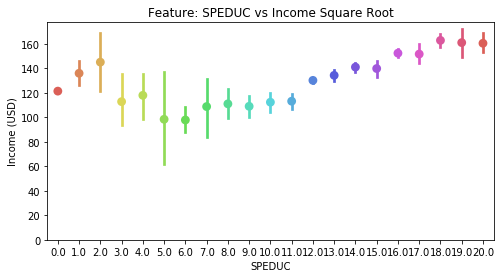

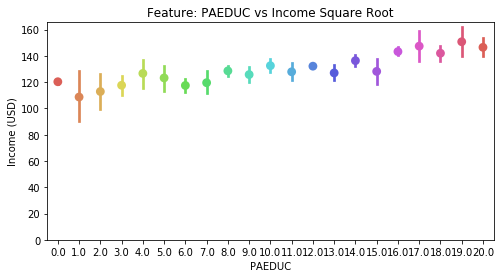

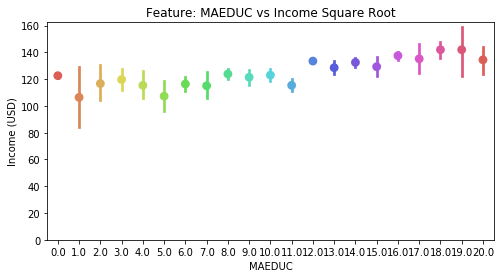

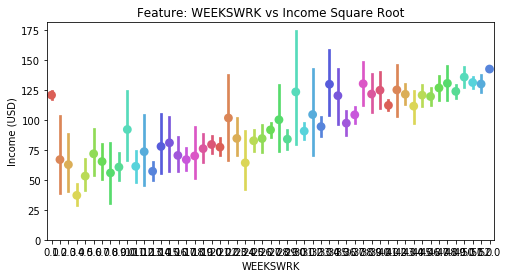

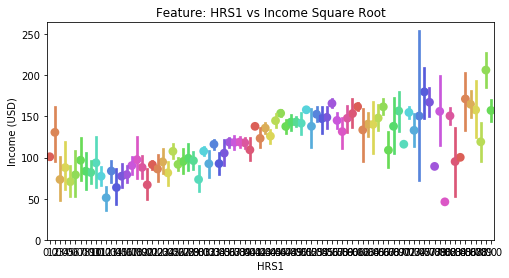

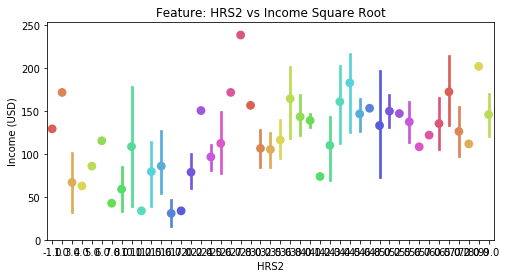

In [22]:
for feature in continuous_feat:
    fig, ax = plt.subplots(figsize=(8,4))
    sns.axes_style("white")
    plt.tick_params(zorder=2.0)
    sns.pointplot(x=feature,
                  y="REALINCSQRT",
                  data=work_mult,
                  alpha=0.1,
                  palette=sns.color_palette("hls", 20),
                  ax=ax)
    plt.title('Feature: {} vs Income Square Root'.format(feature))
    plt.ylabel('Income (USD)')
    plt.ylim(bottom=0)
    plt.show()

All of the features appear the be somewhat linearly related to the outcome. 

Now that I have features which could be used in modeling, I am going to intiate a data frame to hold my features and add any of the continuous features with sufficient correlation with the outcome.

In [23]:
# initiate dataset to hold possible modeling features
features = pd.DataFrame(index=work_mult.index)

In [24]:
contin = []
for feature in continuous_feat:
    a,b = np.corrcoef(work_mult[feature],work_mult['REALINCSQRT'])
    contin.append(a[1])

In [25]:
cont = pd.DataFrame()
cont["Feature"] = continuous_feat
cont["Coefficient"] = contin

In [26]:
# continuous like features that correalate well
cont[abs(cont['Coefficient'])>.1].head()

,Feature,Coefficient
0,EDUC,0.328511
1,SPEDUC,0.197911
2,PAEDUC,0.145723
4,WEEKSWRK,0.277781
5,HRS1,0.380359


In [27]:
for feat in list(cont.Feature[abs(cont['Coefficient'])>.1]):
    features['{}'.format(feat)] = work_mult[feat]

In [28]:
features.head()

,EDUC,SPEDUC,PAEDUC,WEEKSWRK,HRS1
0,12.0,0.0,8.0,52.0,42.0
1,12.0,12.0,0.0,48.0,30.0
2,18.0,16.0,16.0,52.0,5.0
3,11.0,8.0,5.0,40.0,30.0
4,12.0,9.0,8.0,48.0,80.0


Now the GSS continuous features are clean, I can move on to the categorical features.

# Categorial Features

Now I will clean the categorial features. There are many more categorical features than continuous, almost 400. There are so many features, it is much quicker to talk about the features I dropped, that the ones I did not.

__YEAR__, __ID__, __DATEINTV__, __SAMPCODE__, __VSTRAT__, __WTSS__, __WTSSNR__, and __WTSSALL__ are all clerical features which have not place in modeling. 

__AGE__ is being thrown out because it is being used as the control for my mixed effect model. __COHORT__ (Birthyear) is being thrown out because it represents much the same thing.

__SIZE__ (Size of respondant's house) is being thrown out because it is represented in other variables and is misleading as houses cost very different in different areas.

__NUMMEM__ and __NUMWOMEN__, the numbr of men and women respective the respondant has slept with, is being thrown out because they have hard to detect nulls.

__OTHER__ and __OTH16__ refer to whether of not the respondant a Jehovah's Witness, far too niche for modeling.

__PRESTG10__ and __PRESTG105PLUS__, are a little different. They are not responses, but filled in by the GSS survey keepers. They are based on the Census Occupation-Prestige Score of the respondant. This number takes the occupation of the respondant, their parents, and their spouse (if applicable). It then quantifies a person's "occupation-based" social status in a ranked way. PRESTG10 is the actual number (16-80) while PRESTG105PLUS is scaled with more transition ranks (1-99). Though these are very interesting components, and I'm sure would make for a very accurate model, I will not be using them here as it they are made from too many features. If prestige becomes an important factor, I will not be sure just want component of prestige is the most important part.

__RACE__ (respondant race) and __HHRACE__ (race of respondant's household) are being dropped because they both represent respondant racial information, which is better captured in the other feature, RACECEN1, which will be kept.

__FINRELA__, __SATFIN__, and __FINALTER__ all relate to the respondant's answer to question about their financial stability and satisfaction. While these may be perfect good features for accuracy in predicting income, it will not be valuable or interesting for me to conclude that someone who thinks they make little money makes little money. So I will throw these 'obvious' features out.

In [29]:
dropped_feat = ['YEAR','ID','DATEINTV','AGE','COHORT','SIZE','NUMMEN','NUMWOMEN','OTHER','OTH16','SAMPCODE','VSTRAT','PRESTG10',
                'PRESTG105PLUS','WTSS','WTSSNR','WTSSALL','HHTYPE','RESPNUM','RACE','HHRACE','FINRELA','SATFIN','FINALTER']

## Occupational and Industrial Codes

Before I get to selecting all the categorical features, I want to look at the OCC10 and INDUS10 features. They both represent the Occupational and Industrial code of the respondants, and there is data on the occupational and industrial codes of the respondant's spouse and parent's as well. Howevever, these values are a little too specific, they range from 0-9999 and contain detailed information about every type of job someone can have. 

In [30]:
work_mult['OCC10'].describe()

count    13802.000000
mean      4288.664976
std       2586.962770
min          0.000000
25%       2310.000000
50%       4230.000000
75%       5800.000000
max       9999.000000
Name: OCC10, dtype: float64

In [31]:
work_mult['INDUS10'].describe()

count    13802.000000
mean      6312.440516
std       2709.022014
min          0.000000
25%       4770.000000
50%       7380.000000
75%       8270.000000
max       9999.000000
Name: INDUS10, dtype: float64

Though this level of specificity is nice, I would also like to see how more general occupational and industrial trends shape income. I will create and additional feature that represents a grouping of the Occupational and Industrial codes. 

The new OCCG range will be from 1-6, representing: Management, Service employees, Office workers, Contruction/Maintenance workers, Production/Transportation workers, and everyone else.
  
The INDUSG range will be from 1-17; representing: Agriculture, Mining, Utilities, Construction, Manufacturing, Trade, Transportation, Information, Financial, Proffessional/Technical Services, Management/Admin/Waste Service, Education/Health Service, Leisure Services, Other Services, Public Administration, Military, and any other unrepresented industry.

I'll define my cleaning method here.

In [32]:
# group occ code
def GroupOCC(feat):
    grouped = []
    for num in feat:
        if num in range(10,3550):
            # MANAGEMENT, PROFESSIONAL, AND RELATED OCCUPATIONS
            grouped.append(1)
        elif num in range(3600,4660):
            # SERVICE OCCUPATIONS
            grouped.append(2)
        elif num in range(4700,5950):
            # SALES AND OFFICE OCCUPATIONS
            grouped.append(3)
        elif num in range(6000,7640):
            # NATURAL RESOURCES, CONSTRUCTION, AND MAINTENANCE OCCUPATIONS
            grouped.append(4)
        elif num in range(7700,9760):
            # PRODUCTION, TRANSPORTATION, AND MATERIAL MOVING OCCUPATIONS
            grouped.append(5)
        else:
            grouped.append(0)

        
    return grouped

In [33]:
# respondant's industrial code
def GroupINDUS(feat):
    grouped = []
    for num in feat:
        if num in range(160,300):
            # AGRICULTURE, FORESTRY, AND FISHERIES
            grouped.append(1)
        elif num in range(360,500):
            # MINING
            grouped.append(2)
        elif num in range(560,700):
            # UTILITIES
            grouped.append(3)
        elif num in range(760,800):
            # CONSTRUCTION
            grouped.append(4)
        elif num in range(1060,4000):
            # MANUFACTURING
            grouped.append(5)
        elif num in range(4060,6000):
            # WHOLESALE TRADE AND RETAIL TRADE
            grouped.append(6)
        elif num in range(6060,6400):
            # TRANSPORTATION
            grouped.append(7)
        elif num in range(6460,6800):
            # INFORMATION
            grouped.append(8)
        elif num in range(6870,7200):
            # FINANCIAL ACTIVITIES
            grouped.append(9)
        elif num in range(7260,7500):
            # PROFESSIONAL AND TECHNICAL SERVICES
            grouped.append(10)
        elif num in range(7560,8000):
            # MANAGEMENT, ADMINISTRATIVE, AND WASTE SERVICES
            grouped.append(11)
        elif num in range(7850,8480):
            # EDUCATION AND HEALTH SERVICES
            grouped.append(12)
        elif num in range(8550,8700):
            # LEISURE AND HOSPITALITY
            grouped.append(13)
        elif num in range(8760,9300):
            # OTHER SERVICES
            grouped.append(14)
        elif num in range(9360,9600):
            # PUBLIC ADMINISTRATION
            grouped.append(15)
        elif num in range(9660,9880):
            # ACTIVE DUTY MILITARY PERSONNEL (NO CIVILIAN EMPLOYEES)
            grouped.append(16)
        else:
            grouped.append(17)

    return grouped

Now I'll created grouped Occupation and Education codes for respondants, their spouses, and their parents.

### Respondant

In [34]:
work_mult['OCCG'] = GroupOCC(work_mult['OCC10'])

In [35]:
work_mult['INDUSG'] = GroupINDUS(work_mult['INDUS10'])

### Spouse

In [36]:
work_mult['SPOCCG'] = GroupOCC(work_mult['SPOCC10'])

In [37]:
work_mult['SPINDG'] = GroupINDUS(work_mult['SPIND10'])

### Mother

In [38]:
work_mult['MAOCCG'] = GroupOCC(work_mult['MAOCC10'])

In [39]:
work_mult['MAINDG'] = GroupINDUS(work_mult['MAIND10'])

### Father

In [40]:
work_mult['PAOCCG'] = GroupOCC(work_mult['PAOCC10'])

In [41]:
work_mult['PAINDG'] = GroupINDUS(work_mult['PAIND10'])

Now that I have all the categorical features I want to look at for modeling, I will create a new data frame for the categorical GSS features of interest.

In [42]:
income_feat = ['INCOME','RINCOME','CONINC','CONRINC','REALINC','REALRINC','REALINCSQRT']

In [43]:
work_drop = work_mult.drop(dropped_feat+income_feat,1)

## Dropping Relation Features

I will also drop the features that describe the relationship the respondant has the the other members of their household. Any income affecting relationships from these variables would be too soophisticated to model with my limited processing power.

In [44]:
words = ['RELATE','GENDER','OLD','MAR','AWAY','WHERE']
words_col = []
for i in range(1,13):
    for word in words:
        words_col.append(word+str(i))
    

In [45]:
for word in words_col:
    if word in work_drop.columns:
        del work_drop[word]

## Finding Problem Features

I will now search through the categorical feature columns and find those which features which could be useful for modeling. 

I will throw out any column which has more than one fourth null or non-applicable responses, whose columns were more than 20% not applicable responses, or were dominated by at least 90% or more by one value. 

In [46]:
prob_cols = []
for feature in work_drop.columns:
    normals = work_drop[feature].value_counts(normalize=True)
    max_ = max(work_drop[feature])
    # throw out columns many did not answer
    if max_ == 9:
        try:
            a = normals[8] + normals[9]
            if a > 0.25:
                prob_cols.append(feature)
        except:
            a = normals[9]
            if a > 0.25:
                prob_cols.append(feature)
    elif max_ == 99:
        try:
            a = normals[98] + normals[99]
            if a > 0.25:
                prob_cols.append(feature)
        except:
            a = normals[99]
            if a > 0.25:
                prob_cols.append(feature)
    elif max_ == 999:
        try:
            a = normals[998] + normals[999]
            if a > 0.25:
                prob_cols.append(feature)
        except:
            a = normals[999]
            if a > 0.25:
                prob_cols.append(feature)
    
    # throw out columns which were N/A for many
    try:
        a = normals[-1]
        if a > 0.2:
            prob_cols.append(feature)
    except:
        pass
    
    # throw out columns which were N/A for many
    try:
        b = normals[0]
        if b > 0.2:
            prob_cols.append(feature)
    except:
        pass
        
    # throw out columns dominate by one value
    for n in normals:
        if n > 0.9:
            prob_cols.append(feature)

In [47]:
prob_cols = list(set(prob_cols))

In [48]:
len(prob_cols)

261

In [49]:
work_drop = work_drop.drop(prob_cols, 1)

In [50]:
work_drop.head()

,BORN,FAMILY16,RES16,COOP,WHOELSE3,SPDEG,HAPPY,FUND,ETHNUM,PARTNRS5,...,ADULTS,WRKSTAT,SPEDUC_NA,PAEDUC_NA,MAEDUC_NA,OCCG,INDUSG,SPINDG,MAINDG,PAINDG
0,1.0,1.0,1.0,1.0,2.0,7.0,2.0,3.0,1.0,3.0,...,1.0,1.0,2,1,1,5,5,17,6,5
1,1.0,5.0,4.0,8.0,2.0,1.0,2.0,2.0,1.0,-1.0,...,4.0,2.0,1,2,1,2,12,4,12,17
2,1.0,1.0,3.0,1.0,2.0,3.0,1.0,3.0,2.0,1.0,...,3.0,2.0,1,1,1,3,6,10,10,10
3,2.0,1.0,4.0,1.0,2.0,0.0,1.0,2.0,1.0,2.0,...,2.0,2.0,1,1,1,2,12,13,13,13
4,2.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,1.0,-1.0,...,2.0,1.0,1,1,1,2,12,12,14,6


I have selected the features who have the appropriate amount of response density for descriptive modeling. 

Now I will drop all the non response values for each of the selected features.

In [51]:
marital = work_mult['MARITAL'][work_drop.index]
work_drop = work_drop.drop(work_drop[work_drop['MARITAL']==9].index)

for feature in work_drop.columns:
    clean_f = []
    max_ = max(work_drop[feature])
    try:  
        mode = statistics.mode(work_drop[feature])
    except:
        mode=-1
    for i in work_drop.index:
        value = work_drop[feature][i]
        if value == -1 or value == 0:
            if marital[i] == 1:
                clean_f.append(-1)
            else:
                clean_f.append(0)
        elif max_ == 9999 and value == 9998 or value == 9999:
            clean_f.append(mode)
        elif max_ == 999 and value == 998 or value == 999:
            clean_f.append(mode)
        elif max_ == 99 and value == 98 or value == 99:
            clean_f.append(mode)
        elif max_ == 9 and value == 8 or value == 9:
            clean_f.append(mode)
        else:
            clean_f.append(value)
    
    work_drop[feature] = clean_f
        
    work_drop = work_drop.drop(work_drop[work_drop[feature]==-1].index)

## Creating Dummies

With dropped null responses, my data is now 8929 respondants long and 83 categorical features accross. I have reduced the size of my data by quite a bit, but I have ensured that the data I do have is valuable.

The next to do is to convert all of the categorial features into dummy variables. I intend to use Mixed Effect Linear modeling, and it does not handle non-binary categorical data very well.

In [52]:
work_drop.shape

(8929, 83)

In [53]:
features = features.iloc[list(work_drop.index),:]

In [54]:
work_drop = work_drop.astype(str)

In [55]:
work_dums = pd.get_dummies(work_drop)
work_dums.head()

,BORN_0.0,BORN_1.0,BORN_2.0,FAMILY16_0.0,FAMILY16_1.0,FAMILY16_2.0,FAMILY16_3.0,FAMILY16_4.0,FAMILY16_5.0,FAMILY16_6.0,...,PAINDG_15,PAINDG_16,PAINDG_17,PAINDG_2,PAINDG_3,PAINDG_4,PAINDG_5,PAINDG_6,PAINDG_7,PAINDG_8
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
work_dums.shape

(8929, 1497)

By converting the categorical features into dummies, the 83 categorical features have been extended into 1497 dummy features. 

Once again, I will only add those dummy features to the possible modeling feature list if they have sufficient correlation with the outcome.

In [57]:
cor = []
for dummy in work_dums.columns:
    a,b = np.corrcoef(work_dums[dummy],work_mult['REALINCSQRT'][work_dums.index])
    cor.append(a[1])

In [58]:
corr = pd.DataFrame()
corr["Feature"] = list(work_dums.columns)
corr["Coefficient"] = cor

In [59]:
corr[abs(corr['Coefficient'])>.1].head()

,Feature,Coefficient
4,FAMILY16_1.0,0.134979
28,SPDEG_3.0,0.146078
29,SPDEG_4.0,0.103102
30,SPDEG_7.0,-0.167008
34,HAPPY_3.0,-0.107122


In [60]:
print('Adding ',len(corr[abs(corr['Coefficient'])>.1]),' categorical features.')

Adding  78  categorical features.


In [61]:
for feat in list(corr.Feature[abs(corr['Coefficient'])>.1]):
    features['{}'.format(feat)] = work_dums[feat]

# Feature Overview

Now that I have thrown out the superfluous features, I am left only with those which correlation linearly with the outcome. 

This leaves me with a features set consisting of 8929 respondants and 83 features.

In [62]:
features.shape

(8929, 83)

In [63]:
features.head()

,EDUC,SPEDUC,PAEDUC,WEEKSWRK,HRS1,FAMILY16_1.0,SPDEG_3.0,SPDEG_4.0,SPDEG_7.0,HAPPY_3.0,...,SPEDUC_NA_2,PAEDUC_NA_1,PAEDUC_NA_2,OCCG_1,OCCG_2,INDUSG_10,INDUSG_13,INDUSG_15,SPINDG_11,SPINDG_17
0,12.0,0.0,8.0,52.0,42.0,1,0,0,1,0,...,1,1,0,0,0,0,0,0,0,1
2,18.0,16.0,16.0,52.0,5.0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,10.0,0.0,0.0,52.0,0.0,1,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
7,13.0,0.0,12.0,52.0,42.0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
9,18.0,0.0,12.0,52.0,40.0,1,0,0,1,0,...,1,1,0,1,0,0,0,0,0,1


In [64]:
f = features.corr()

In [65]:
f.shape

(83, 83)

# Getting Featues Importances

Now that I have the features which are most likely to perform well in a descriptive linear model, I want to determine which features are the most important when determining income. 

I will do this using emsemble modeling. Specifically, I will using a Random Forest model and a Gradient Boosted Decision Tree model to get 2 different sets of features importances. I will use the importances of 2 different models to better ensure accuracy of my predicted featurs importances

## Random Forest Importances

I will first get the importances from the Random Forest model.

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
outcome = work_mult['REALINCSQRT'][features.index]

In [68]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=4, random_state=42)

In [69]:
rf.fit(features, outcome)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [70]:
rf.score(features, outcome)

0.9330328521966299

Now that my random forest model is fit, I will plot my feature importances.

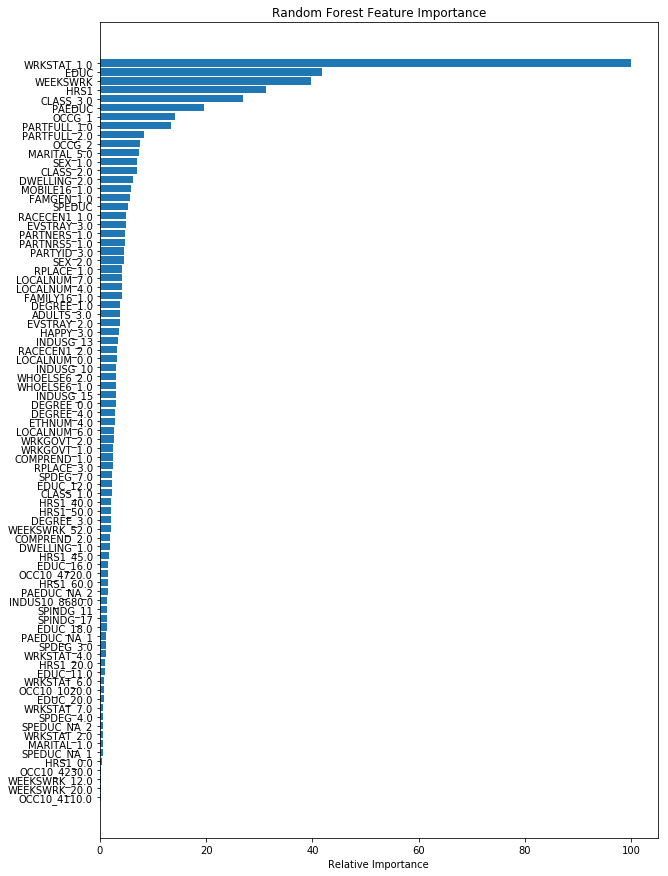

In [71]:
imp = rf.feature_importances_
# Make importances relative to max importance.
imp = 100.0 * (imp / imp.max())
sorted_idx = np.argsort(imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, imp[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

importances_rf = pd.DataFrame(index=list(features.columns[sorted_idx]))
importances_rf['Imp'] = list(imp[sorted_idx])

In [72]:
print('Top 10 most important Random Forest Features')
display(importances_rf.sort_values('Imp', ascending=False).head(10))

Top 10 most important Random Forest Features


,Imp
WRKSTAT_1.0,100.000000
EDUC,41.757016
WEEKSWRK,39.678502
HRS1,31.275249
CLASS_3.0,26.927167
PAEDUC,19.570062
OCCG_1,14.179692
PARTFULL_1.0,13.471288
PARTFULL_2.0,8.269286
OCCG_2,7.576574


The most important random forest features were __WRKSTAT_1.0__, people who work full time, __EDUC__, respondant's education level, __WEEKSWRK__, how many weeks per year the respondant works ,__HRS1__, how many hours the repsondant works per week, __CLASS_3.0__, respondants who identify as middle class, __PAEDUC__, respondant's father's education level, __OCCG_1__, respondants who work in manangement positions, __PARTFULL_1.0__, respondants who were full-time, __PARTFULL_2.0__, respondants who work full-time, and __OCCG_2__, and respondants who work in service occupations. 

## Gradient Boosted Importances

I will find the feature importances using the Gradient Boosted modeling next.q

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

In [74]:
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.2, random_state=42)

In [75]:
gb.fit(features, outcome)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [76]:
gb.score(features, outcome)

0.6475245006823778

Now that my random forest model is fit, I will plot my feature importances.

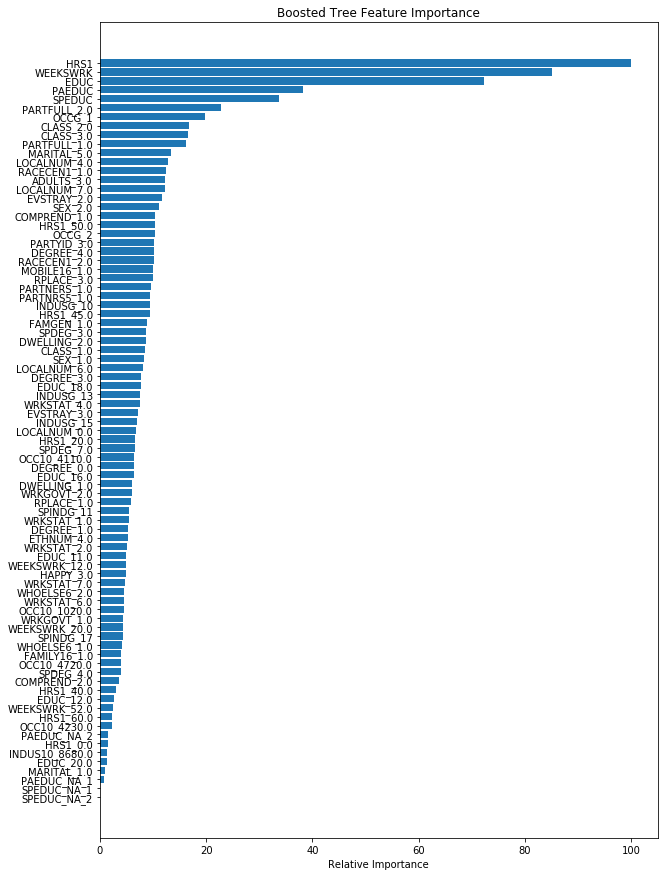

In [77]:
imp = gb.feature_importances_
# Make importances relative to max importance.
imp = 100.0 * (imp / imp.max())
sorted_idx = np.argsort(imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, imp[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Boosted Tree Feature Importance')
plt.show()

importances_gb = pd.DataFrame(index=list(features.columns[sorted_idx]))
importances_gb['Imp'] = list(imp[sorted_idx])

In [78]:
print('Top 10 most important Gradient Boosted Features')
display(importances_gb.sort_values('Imp', ascending=False).head(10))

Top 10 most important Gradient Boosted Features


,Imp
HRS1,100.000000
WEEKSWRK,85.018354
EDUC,72.287124
PAEDUC,38.197314
SPEDUC,33.713259
PARTFULL_2.0,22.715253
OCCG_1,19.699321
CLASS_2.0,16.776701
CLASS_3.0,16.573997
PARTFULL_1.0,16.199329


The most important random forest features were __HRS1__, how many hours worked per week, __WEEKSWRK__, how many weeks worked per year,  __EDUC__, respondant's education level, __PAEDUC__, respondant's feather's education level, __SPEDUC__, respondant's spouse's education level, __PARTFULL_2.0__, respondants who were part-time, __OCCG_1__, respondants who work in manangement positions, __CLASS_2.0__, respondants who identify as working class, __CLASS_3.0__, respondants who identify as middle class, and __PARTFULL_1.0__, respondants who were full-time.

# Dropping Correalated Features

Because I am using a linear model, it will be very important for me to prevent to much multi-colinearity. This simply means that the features I am using cannot correlate with each other. This is important because having correlating features creates overrespresentation of certain factors in the data and will lead to model error.

I will set my correaltion threshold to 0.7, any 2 features which have a correlation greater than that will raise an alarm and be inspected.  The feature between the 2 which has the highest importance in both the random forest and the gradient boosted feature set will the kept.  If neither feature satisfy this, I will choose the feature which had the greatest importance overall.  

In [79]:
corr_feats_ind = []
corr_feats_col = []
for i in range(0,f.shape[0]):
    for c in range(0,f.shape[1]):
        if i != c:
            if f.iloc[i,c] > 0.7:
                corr_feats_ind.append(f.index[i])
                corr_feats_col.append(f.columns[c])

In [80]:
corrs = pd.DataFrame()
corrs['Feat1'] = corr_feats_ind
corrs['Feat2'] = corr_feats_col

In [81]:
corrs.head()

,Feat1,Feat2
0,SPEDUC,MARITAL_1.0
1,SPEDUC,SPEDUC_NA_1
2,PAEDUC,PAEDUC_NA_1
3,HRS1,WRKSTAT_1.0
4,SPDEG_7.0,SPEDUC_NA_2


In [82]:
dropped_feats = []
for i in range(0,corrs.shape[0]):
    feat1 = corrs['Feat1'][i]
    feat2 = corrs['Feat2'][i]
    if feat1 not in dropped_feats and feat2 not in dropped_feats:
        imp1_rf = importances_rf.loc[feat1,'Imp']
        imp1_gb = importances_gb.loc[feat1,'Imp']
        imp2_rf = importances_rf.loc[feat2,'Imp']
        imp2_gb = importances_gb.loc[feat2,'Imp']
        if imp1_rf > imp2_rf and imp1_gb > imp2_gb:
            dropped_feats.append(feat2)
        elif imp1_rf < imp2_rf and imp1_gb < imp2_gb:
            dropped_feats.append(feat1)
        else:
            if imp1_gb > imp1_rf and imp2_gb > imp2_rf:
                if imp1_gb > imp2_gb:
                    dropped_feats.append(feat2)
                else:
                    dropped_feats.append(feat1)
            elif imp1_gb < imp1_rf and imp2_gb < imp2_rf:
                if imp1_rf > imp2_rf:
                    dropped_feats.append(feat2)
                else:
                    dropped_feats.append(feat1)
            else:
                if abs(imp1_rf-imp2_rf) > abs(imp1_gb-imp2_gb):
                    if imp1_rf > imp2_rf:
                        dropped_feats.append(feat2)
                    else:
                        dropped_feats.append(feat1)
                elif abs(imp1_gb-imp2_gb) > abs(imp1_rf-imp2_rf):
                    if imp1_gb > imp2_gb:
                        dropped_feats.append(feat2)
                    else:
                        dropped_feats.append(feat1)
                else:
                    print('{} imps  rf: {}  gb: {}'.format(feat1,round(imp1_rf,2),round(imp1_gb,2)))
                    print('{} imps  rf: {}  gb: {}\n'.format(feat2,round(imp2_rf,2),round(imp2_gb,2)))

In [83]:
dropped_feats

['MARITAL_1.0',
 'SPEDUC_NA_1',
 'PAEDUC_NA_1',
 'WRKSTAT_1.0',
 'SPEDUC_NA_2',
 'SPINDG_17',
 'HRS1_0.0',
 'EDUC_16.0',
 'EVSTRAY_3.0',
 'INDUS10_8680.0']

In [84]:
X = features.drop(dropped_feats,1)

## Rerunning Importance without Correlating Features

Now that I have removed the correlating features, I want to see if my overall feature importances have changed at all

In [85]:
rf2 = RandomForestRegressor(n_estimators=300, n_jobs=4, random_state=42)

In [86]:
rf2.fit(X, outcome)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
rf2.score(X, outcome)

0.9335518945053004

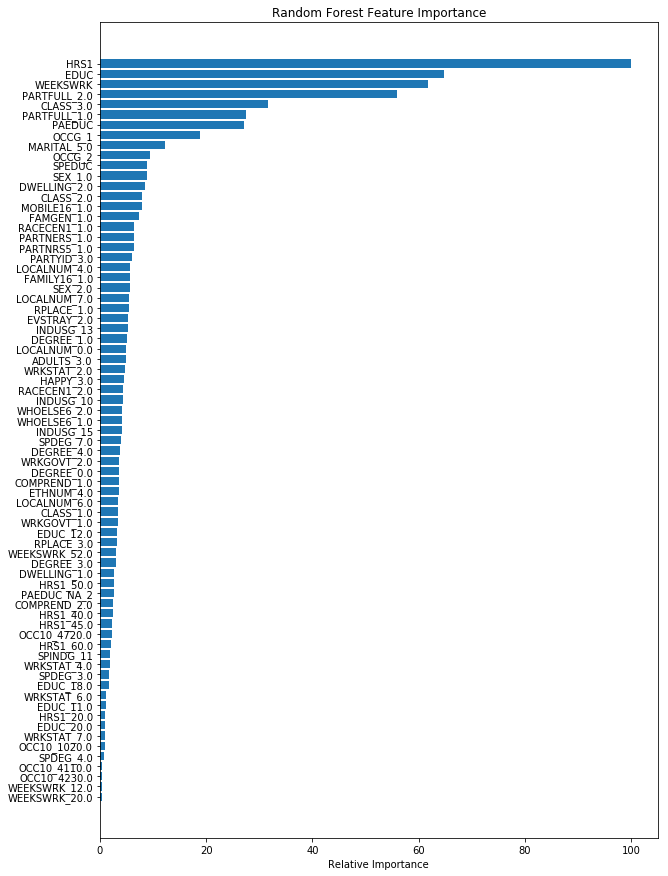

In [88]:
imp = rf2.feature_importances_
# Make importances relative to max importance.
imp = 100.0 * (imp / imp.max())
sorted_idx = np.argsort(imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, imp[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

importances_rf2 = pd.DataFrame(index=list(X.columns[sorted_idx]))
importances_rf2['Imp'] = list(imp[sorted_idx])

In [89]:
print('Top 10 most important Random Forest Features')
importances_rf2.sort_values('Imp', ascending=False).head(4)

Top 10 most important Random Forest Features


,Imp
HRS1,100.000000
EDUC,64.846428
WEEKSWRK,61.843487
PARTFULL_2.0,55.960400


The most important features amoung the random forest have changed. The previous most important features were, in order: __WRKSTAT_1.0__, __EDUC__, __WEEKSWRK__, __HRS1__, __CLASS_3.0__, __PAEDUC__, __OCCG_1__, __PARTFULL_1.0__, __PARTFULL_2.0__, __OCCG_2__. 

They are now __HRS1__, hours worked, __EDUC__, education level, __WEEKSWRK__, weeks worked per year, __PARTFULL_2.0__, part-time workers, __CLASS_3.0__, respondants identifying as middle class, __PARTFULL_1.0__, full-time workers, __PAEDUC__, father's education level, __OCCG_1__, working a management occupation, __MARITAL_5.0__, never having been married, and __OCCG_2__, working a service job.

So the redundant full-time feature was thrown out and replaced with a feature indicating never having been married. Additionally, the order and overall importance of each of the features has drastically changed.

In [90]:
gb2 = GradientBoostingRegressor(n_estimators=300, learning_rate=0.2, random_state=42)

In [91]:
gb2.fit(X, outcome)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [92]:
gb2.score(X, outcome)

0.6436492494410828

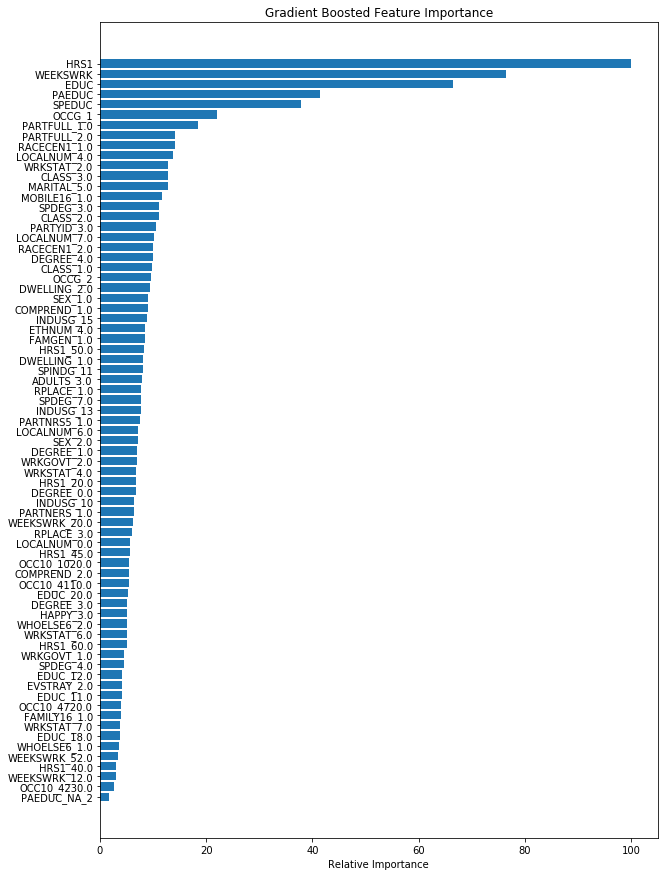

In [93]:
imp = gb2.feature_importances_
# Make importances relative to max importance.
imp = 100.0 * (imp / imp.max())
sorted_idx = np.argsort(imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, imp[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosted Feature Importance')
plt.show()

importances_gb2 = pd.DataFrame(index=list(X.columns[sorted_idx]))
importances_gb2['Imp'] = list(imp[sorted_idx])

In [94]:
print('Top 10 most important Gradient Boosted Features')
importances_gb2.sort_values('Imp', ascending=False).head(4)

Top 10 most important Gradient Boosted Features


,Imp
HRS1,100.000000
WEEKSWRK,76.389717
EDUC,66.537065
PAEDUC,41.384830


The most important random forest features were __HRS1__, how many hours worked per week, __WEEKSWRK__, how many weeks worked per year,  __EDUC__, respondant's education level, __PAEDUC__, respondant's feather's education level, __SPEDUC__, respondant's spouse's education level, __PARTFULL_2.0__, respondants who were part-time, __OCCG_1__, respondants who work in manangement positions, __CLASS_2.0__, respondants who identify as working class, __CLASS_3.0__, respondants who identify as middle class, and __PARTFULL_1.0__, respondants who were full-time.

The features for the gradient boosted model have also changed, though the ones of the top 5 importance have remained the same.

The most important random forest features were __HRS1__, how many hours worked per week, __WEEKSWRK__, how many weeks worked per year,  __EDUC__, respondant's education level, __PAEDUC__, respondant's feather's education level, __SPEDUC__, respondant's spouse's education level, __OCCG_1__, respondants who work in manangement positions, __PARTFULL_1.0__, respondants who were full-time, __PARTFULL_2.0__, respondants who were part-time, __RACECEN1__, white respondants, and __LOCALNUM_4.0__, having 100-499 employees at respondant's job.

# Selecting Features from Models

Now that I have the true feature importance using non-correlating features, I can use the same ensemble models I used to generate feature importances. This will give me 2 possible feature sets to test with.

In [95]:
from sklearn.feature_selection import SelectFromModel

In [96]:
rfsel = SelectFromModel(rf2, prefit=True)
X_rfsel = rfsel.transform(X)

print('Number of Random Forest Features:')
print(X_rfsel.shape[1])

Number of Random Forest Features:
12


In [97]:
rfsel = SelectFromModel(rf2, prefit=True, threshold=.05)
X_rfsel = rfsel.transform(X)

print('Number of Random Forest Features:')
print(X_rfsel.shape[1])

Number of Random Forest Features:
4


In [98]:
X_rfsel = pd.DataFrame(X_rfsel)

In [99]:
# give the gb features the appropriate name
new_cols = []
for c in X_rfsel.columns:
    for i in X.columns:
        if list(X_rfsel[c]) == list(X[i]):
            new_cols.append(i)
            
X_rfsel.columns = new_cols

In [100]:
gbsel = SelectFromModel(gb2, prefit=True)
X_gbsel = gbsel.transform(X)

print('Number of Gradient Boosted Features:')
print(X_gbsel.shape[1])

Number of Gradient Boosted Features:
14


In [101]:
X_gbsel = pd.DataFrame(X_gbsel)

In [102]:
# give the gb features the appropriate name
new_cols = []
for c in X_gbsel.columns:
    for i in X.columns:
        if list(X_gbsel[c]) == list(X[i]):
            new_cols.append(i)
            
X_gbsel.columns = new_cols

After the selection is done, I am left with 2 features sets. The Random Forest feature set has 12 features while the Gradient Boosted one has 14.

# Testing Feature Sets through Modeling 

Since my end goal is to use use descriptiv modeling with linear mixed effects, I do not need my end feature set to be able to produce a completely accurate model. Still, if my features cannot model the the data consisently or shows signs of being too overfit, it is probably too unhealthy to use. 

The will test both of my feature sets with Random Forest, Gradient Boosted, and OLS Linear Regression models. But first, I will split my data into training and testing set.

In [103]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

In [104]:
modeling_split = train_test_split(X_rfsel, X_gbsel, outcome, test_size=0.4, random_state=12345)

Xtrain_rfsel, Xtest_rfsel, Xtrain_gbsel, Xtest_gbsel, Ytrainsqrt, Ytestsqrt, = modeling_split

In [105]:
X_rfsel = features[Xtrain_rfsel.columns]
X_gbsel = features[Xtrain_gbsel.columns]
Ysqrt = work_mult['REALINCSQRT'][features.index]

In [106]:
results = pd.DataFrame(index=['Traing Score','Testing Score','CV Score'])

## Random Forest

Testing my data using a random forst model

In [107]:
rf_rf = RandomForestRegressor(n_estimators=250, n_jobs=4, random_state=42)

In [108]:
rf_rf.fit(Xtrain_rfsel, Ytrainsqrt)
train = rf_rf.score(Xtrain_rfsel, Ytrainsqrt)
print('RF Features Traing Score: ',train)
test = rf_rf.score(Xtest_rfsel, Ytestsqrt)
print('\nRF Features Testing Score: ',test)
cvall = cross_val_score(rf_rf, X_rfsel, Ysqrt, cv=5)
print('\nRF Features Cross Validation Results:: ')
cvall

RF Features Traing Score:  0.6232097025331084

RF Features Testing Score:  0.34151748919499036

RF Features Cross Validation Results:: 


array([0.36599486, 0.37795867, 0.28553914, 0.26303594, 0.32276184])

In [109]:
results['RF: RF Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

In [110]:
rf_gb = RandomForestRegressor(n_estimators=250, n_jobs=4, random_state=42)

In [111]:
rf_gb.fit(Xtrain_gbsel, Ytrainsqrt)
train = rf_gb.score(Xtrain_gbsel, Ytrainsqrt)
print('GB Features Traing Score: ',train)
test  = rf_gb.score(Xtest_gbsel, Ytestsqrt)
print('\nGB Features Traing Score: ',test)
cvall = cross_val_score(rf_gb, X_gbsel, Ysqrt, cv=5)
print('\nGF Features Cross Validation Results:: ')
cvall

GB Features Traing Score:  0.8936195139878303

GB Features Traing Score:  0.4257490368040185

GF Features Cross Validation Results:: 


array([0.45929871, 0.44701194, 0.39812315, 0.34754801, 0.40294967])

In [112]:
results['RF: GB Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

The Random Forest model seems to be a little unstable, but nothing that isn't unusal for a random forest. The RF feature set appears to perform marginally better, but not by too much.

## Gradient Boosted Decision Trees

Now I will test both the RF and GB feature sets using a Gradient Boosted regressor model. 

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
gb_rfsel = GradientBoostingRegressor(n_estimators=250, learning_rate=.2, random_state=42)

In [115]:
gb_rfsel.fit(Xtrain_rfsel, Ytrainsqrt)
train = gb_rfsel.score(Xtrain_rfsel, Ytrainsqrt)
print('RF Features Traing Score: ',train)
test = gb_rfsel.score(Xtest_rfsel, Ytestsqrt)
print('\nRF Features Testing Score: ',test)
cvall = cross_val_score(gb_rfsel, X_rfsel, Ysqrt, cv=5)
print('\nRF Features Cross Validation Results:: ')
cvall

RF Features Traing Score:  0.4888684216723296

RF Features Testing Score:  0.41009284033871235

RF Features Cross Validation Results:: 


array([0.42768913, 0.46495135, 0.35975761, 0.34684908, 0.4028397 ])

In [116]:
results['GB: RF Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

In [117]:
gb_gbsel = GradientBoostingRegressor(n_estimators=250, learning_rate=.2, random_state=42)

In [118]:
gb_gbsel.fit(Xtrain_gbsel, Ytrainsqrt)
train = gb_gbsel.score(Xtrain_gbsel, Ytrainsqrt)
print('GB Features Traing Score: ',train)
test  = gb_gbsel.score(Xtest_gbsel, Ytestsqrt)
print('\nGB Features Traing Score: ',test)
cvall = cross_val_score(gb_gbsel, X_gbsel, Ysqrt, cv=5)
print('\nGF Features Cross Validation Results:: ')
cvall

GB Features Traing Score:  0.5918720077836954

GB Features Traing Score:  0.4714521407090572

GF Features Cross Validation Results:: 


array([0.49639711, 0.51556742, 0.45041602, 0.42098825, 0.46444596])

In [119]:
results['GB: GB Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

The Gradient Boosted regressor it much more stable than the Random Forest model.  This makes me much more confident that the previous instability shown in the Random Forest model was simply due to normal random forest behavior.

## Linear Regression

Now I will look and see how both of my feature sets perform when used in a linear regression model. Stability in this model is key since my final descriptive model will be a linear-based one.

In [120]:
from sklearn.linear_model import LinearRegression

In [121]:
reg_rfsel = LinearRegression().fit(Xtrain_rfsel, Ytrainsqrt)

In [122]:
train = reg_rfsel.score(Xtrain_rfsel, Ytrainsqrt)
print('RF Features Traing Score: ',train)
test = reg_rfsel.score(Xtest_rfsel, Ytestsqrt)
print('\nRF Features Testing Score: ',test)
cvall = cross_val_score(reg_rfsel, X_rfsel, Ysqrt, cv=5)
print('\nRF Features Cross Validation Results:: ')
cvall

RF Features Traing Score:  0.3698948275657977

RF Features Testing Score:  0.3888911501460749

RF Features Cross Validation Results:: 


array([0.37995739, 0.42547346, 0.29270051, 0.33304397, 0.40543646])

In [123]:
results['LR: RF Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

In [124]:
reg_gbsel = LinearRegression().fit(Xtrain_gbsel, Ytrainsqrt)

In [125]:
train = reg_gbsel.score(Xtrain_gbsel, Ytrainsqrt)
print('GB Features Traing Score: ',train)
test  = reg_gbsel.score(Xtest_gbsel, Ytestsqrt)
print('\nGB Features Traing Score: ',test)
cvall = cross_val_score(reg_gbsel, X_gbsel, Ysqrt, cv=5)
print('\nGF Features Cross Validation Results:: ')
cvall

GB Features Traing Score:  0.4596553996464863

GB Features Traing Score:  0.4640038808208745

GF Features Cross Validation Results:: 


array([0.47545777, 0.48834912, 0.40779742, 0.42329912, 0.46895398])

In [126]:
results['LR: GB Feats'] = [round(train,3),round(test,3),round(cvall.mean(),3)]

Both of the feature sets seem stable enough in the linear model to be used.

## Modeling Results

A general overview of the modeling performed on both feature sets. The column indicates which model and feature set is being used, while the row indicates the type of value.

In [127]:
display(results)

,RF: RF Feats,RF: GB Feats,GB: RF Feats,GB: GB Feats,LR: RF Feats,LR: GB Feats
Traing Score,0.623,0.894,0.489,0.592,0.370,0.460
Testing Score,0.342,0.426,0.410,0.471,0.389,0.464
CV Score,0.323,0.411,0.400,0.470,0.367,0.453


All of my models indicate or at least don't rule out either feature set as being an effect indicator of income.

The Random Forest features appear to work slightly better in every model, but not enough to be very significant.

# Finalizing Features through Descriptive OLS

Now that I know that both of my feature sets can be used for descriptive modeling, I need to determine which features I will actually use. I intend to use a Linear Mixed Effect model to decribe the relationship between each of my features. These types of model are incredibly powerful but also incredibly complicated, and becomed overburdened extremely easy with very few features.

My goal is to reduce the number of feature sets from 2 to 1, and the number of features to just 4. 

In [128]:
import statsmodels.api as sm

## Combining Feature Set

I need to combine the Random Forest determined features and the Gradient Boosted determiend features into one date set to observed the features in one model.  I can already begin to discard features by only looking at those features which are shared between both featue sets.

In [129]:
shared_features = list(set(Xtrain_gbsel.columns).intersection(Xtrain_rfsel.columns))

In [130]:
Xshar = shared_features
Xtrain_ft = Xtrain_gbsel[shared_features]
Xtest_ft = Xtest_gbsel[shared_features]
X_ft = features[shared_features]

## Determining by P-value

Now that I have all my feature is one set.  I will run a descriptive OLS model on the shared feature set, and detemrine which features to keep based on their p-values in the linear model. This is the best final test for the importance of my features, as the final model I use will be a linear model, so I want the features which I know will perform best in a linear model.

In [131]:
ols_ft = sm.OLS(Ysqrt, sm.add_constant(X_ft))
ols_ft2 = ols_ft.fit()
print(ols_ft2.summary())

                            OLS Regression Results                            
Dep. Variable:            REALINCSQRT   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     1358.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):               0.00
Time:                        22:32:23   Log-Likelihood:                -46094.
No. Observations:                8929   AIC:                         9.220e+04
Df Residuals:                    8924   BIC:                         9.223e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.9622      2.600      2.293   

In [132]:
ols_ft2.pvalues

const            2.187767e-02
EDUC            1.251693e-243
HRS1            6.126732e-110
WEEKSWRK        2.503748e-105
PARTFULL_2.0    4.171138e-247
dtype: float64

The features with the top 4 p-values are __HRS1__, hours worked in a week, __PARTFULL_2.0__, being a part-time worker, __EDUC__, respondant's education level, and finally __WEEKSWRK__, the weeks worked in a year.

# Final Feature Set

I have now determined my final feature set. The hours the respondant works in one week, if the respondant is a part-time worker, the respondant's education level, and the weeks the respondant works in one year.

In [133]:
Xtrain_ft = Xtrain_ft[['HRS1','PARTFULL_2.0','EDUC','WEEKSWRK']]
Xtest_ft = Xtest_ft[['HRS1','PARTFULL_2.0','EDUC','WEEKSWRK']]
X_ft = X_ft[['HRS1','PARTFULL_2.0','EDUC','WEEKSWRK']]

In [134]:
ols_rfsel = sm.OLS(Ysqrt, X_ft)
ols_rfsel2 = ols_rfsel.fit()
print(ols_rfsel2.summary())

                            OLS Regression Results                            
Dep. Variable:            REALINCSQRT   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 2.115e+04
Date:                Tue, 16 Oct 2018   Prob (F-statistic):               0.00
Time:                        22:32:25   Log-Likelihood:                -46097.
No. Observations:                8929   AIC:                         9.220e+04
Df Residuals:                    8925   BIC:                         9.223e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
HRS1             0.5976      0.026     23.427   

This feature set looks great! I will export it so it can used in the next and final part.

In [135]:
work_ft = X_ft
work_ft['Target'] = Ysqrt
work_ft.to_csv('C:\\Code\\SSP\\workft.csv')

In [136]:
#work_all = work_mult.iloc[X_ft.index,:]
#work_all.to_csv('C:\\Code\\SSP\\workall.csv')